<center><h2> Subsurface acoustics from biogeochemical floats as a pathway to scalable autonomous observations of global surface wind </h2></center>
    
<center><h3> Analysis and figures </h3></center>

**L. Delaigue<sup>1</sup>\, P. Cauchy<sup>2</sup>, D. Cazau<sup>3</sup>, R. Bozzano<sup>4</sup>, S. Pensieri<sup>4</sup>, A. Gros-Martial<sup>5</sup>, J. Bonnel<sup>6</sup>, E. Leymarie<sup>1</sup> and H. Claustre<sup>1</sup>**

<sup>1</sup>Sorbonne Université, CNRS, Laboratoire d'Océanographie de Villefranche, LOV, 06230 Villefranche-sur-Mer, France

<sup>2</sup>Institut des sciences de la mer (ISMER), Université du Québec à Rimouski (UQAR), Rimouski, Canada

<sup>3</sup>ENSTA, Lab-STICC, UMR CNRS 6285, Brest, France

<sup>4</sup>Institute for the Study of Anthropic Impact and Sustainability in the Marine Environment (IAS), Consiglio Nazionale delle Ricerche (CNR), Genoa, Italy

<sup>5</sup>Centre d’Études Biologiques de Chizé, CNRS, Villiers-en-bois, France

<sup>6</sup>Marine Physical Laboratory, Scripps Institution of Oceanography, University of California San Diego, La Jolla, CA, 92093, USA


## Abstract

Wind forcing plays a pivotal role in driving upper-ocean physical and biogeochemical processes, yet direct wind observations remain sparse in many regions of the global ocean. While passive acoustic techniques have been used to estimate wind speed from moored and mobile platforms, their application to profiling floats has been demonstrated only in limited cases and remains largely unexplored. Here, we report on the first deployment of a Biogeochemical-Argo (BGC-Argo) float equipped with a passive acoustic sensor, aimed at detecting wind-driven surface signals from depth. The float was deployed in the northwestern Mediterranean Sea near the DYFAMED meteorological buoy from February to April 2025, operating at parking depths of 500–1000 m. We demonstrate that wind speed can be successfully retrieved from subsurface ambient noise using established acoustic algorithms, with float-derived estimates showing good agreement with collocated surface observations from the DYFAMED buoy. To evaluate the potential for broader application, we simulate a remote deployment scenario by refitting the acoustic model of Nystuen et al. (2015) using ERA5 reanalysis as a proxy for surface wind. Refitting the model to ERA5 data demonstrates that the float–acoustic–wind relationship is generalizable in moderate conditions, but high-wind regimes remain systematically biased—especially above 10 m s-1. Finally, we apply a residual learning framework to correct these estimates using a limited subset of DYFAMED wind data, simulating conditions where only brief surface observations—such as those from a ship during float deployment—are available. The corrected wind time series achieved a 37% reduction in RMSE and improved the coefficient of determination (R2) from 0.85 to 0.91, demonstrating the effectiveness of combining reanalysis with sparse in situ fitting. This framework enables the retrieval of fine-scale wind variability not captured by reanalysis alone, supporting a scalable strategy for float-based wind monitoring in data-sparse ocean regions—with important implications for quantifying air–sea exchanges, improving biogeochemical flux estimates, and advancing global climate observations.

## What to expect from this notebook?

#### This notebook provides a complete walkthrough of the data processing and analysis workflows used in this study. It includes code for preprocessing float and reference datasets, computing acoustic metrics, applying and refitting empirical wind retrieval models, evaluating performance against in situ and reanalysis wind products, and generating all associated figures and metrics reported in the paper.

____________

## Import libraries

In [1]:
# === Standard Library ===
import os
import sys
import glob
import re
from datetime import datetime, timedelta

# === Core Scientific Libraries ===
import numpy as np
import pandas as pd
import xarray as xr

# === Scientific Tools ===
from scipy import stats
from scipy.stats import linregress
from scipy.spatial import cKDTree
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d, PchipInterpolator

# Handle compatibility for cumulative integration
try:
    from scipy.integrate import cumulative_trapezoid as cumtrapz
except ImportError:
    from scipy.integrate import cumtrapz  # for older SciPy versions

# === Visualization ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Geospatial ===
from geopy.distance import geodesic

# === Ocean Chemistry ===
import PyCO2SYS as co2sys
import pyseaflux

# === Progress Bar ===
from tqdm import tqdm

## 1 - Process raw float data

In [2]:
# Define the path pattern for all matching files
file_pattern = "data/float/csv/lovuse024c_*.csv"  # Adjust the folder path if needed

# Find all matching CSV files
csv_files = glob.glob(file_pattern)

# Define coordinate mapping (station_number -> (latitude, longitude))
coordinate_map = {
    # First deployment
    "040": (43.698656, 7.308651),
    "041": (43.395203, 7.867331),
    "042": (43.385816, 7.835610),
    "043": (43.383342, 7.805394),
    "044": (43.374554, 7.780598),
    "045": (43.347018, 7.761803),
    "046": (43.318718, 7.743787),
    "047": (43.306527, 7.715931),
    "048": (43.293565, 7.683848),
    "049": (43.271333, 7.634016),
    "050": (43.250653, 7.578438),
    "051": (43.237131, 7.537831),
    "052": (43.221096, 7.488428),
    "053": (43.181266, 7.432160),
    "054": (43.143442, 7.408066),
    "055": (43.113340, 7.377611),
    "056": (43.094762, 7.322352),
    "057": (43.080311, 7.263309),
    
    # Second deployment
    "058": (43.417590, 7.798665),  
    "059": (43.387746, 7.777208),
    "060": (43.363777, 7.730860),
    "061": (43.342675, 7.640585),
    "062": (43.313547, 7.565492),
    "063": (43.266750, 7.461486),
    "064": (43.240656, 7.400188),
    "065": (43.222551, 7.300435),
    "066": (43.208608, 7.130404),
    "067": (43.173637, 6.977106),
    "068": (43.167145, 6.954846),
    "069": (43.173564, 6.957003)
}

# List to store DataFrames
float_data_list = []

# Process each file
for file in csv_files:
    # Extract station number from filename
    match = re.search(r'lovuse024c_(\d{3})_', file)
    if match:
        station_number = match.group(1)  # Extract station number
        if station_number in coordinate_map:
            lat, lon = coordinate_map[station_number]

            # Load CSV file
            df = pd.read_csv(file, sep=",")
            
            # Add latitude, longitude, and station number columns
            df["Latitude"] = lat
            df["Longitude"] = lon
            df["StationNumber"] = station_number  # Store station number
            
            # Store in list
            float_data_list.append(df)

# Combine all files into one DataFrame
float_data = pd.concat(float_data_list, ignore_index=True)

# Convert Date column to datetime
float_data["Date"] = pd.to_datetime(float_data["Date"])

# Separate data based on SensorType
sbe41_data = float_data[float_data["SensorType"] == "sbe41"].copy()
pal_data = float_data[float_data["SensorType"] == "pal"].copy()
do_data = float_data[float_data["SensorType"] == "do"].copy()

# Convert Date to matplotlib float format for KDTree
sbe41_data["datenum"] = sbe41_data["Date"].map(mdates.date2num)
pal_data["datenum"] = pal_data["Date"].map(mdates.date2num)
do_data["datenum"] = do_data["Date"].map(mdates.date2num)

# Ensure Pressure is numeric
sbe41_data["Pressure_dbar"] = pd.to_numeric(sbe41_data["Pressure_dbar"], errors="coerce")
pal_data["Pressure_dbar"] = pd.to_numeric(pal_data["Pressure_dbar"], errors="coerce")
do_data["Pressure_dbar"] = pd.to_numeric(do_data["Pressure_dbar"], errors="coerce")

# DO remains the base dataset (7328 rows)
final_data = do_data.copy()

# Prepare empty lists for the new matched columns
sbe41_matched_cols = {col: [] for col in sbe41_data.columns if col not in ["datenum", "Pressure_dbar", "PhaseName", "SensorType"]}
pal_matched_cols = {col: [] for col in pal_data.columns if col not in ["datenum", "Pressure_dbar", "PhaseName", "SensorType"]}

# Normalization by bandwidth to get SPL in dB re 1 µPa²/Hz from Abysens
# coeff = 10* log10 ( freq_max - freq_min )
# freq_max = fc*2 ** (1. / 6)
# freq_min =  fc*2 ** (-1. / 6)
# avec fc la fréquence centrale de la bande
# so the frequency_correction is really the normaliwation to SPL in dB re 1 µPa²/Hz
frequency_correction = {
    "f_25000Hz": -37.69, "f_20000Hz": -36.69, "f_16000Hz": -35.69, "f_12500Hz": -34.68, 
    "f_10000Hz": -33.68, "f_8000Hz": -32.68, "f_6300Hz": -31.67, "f_5000Hz": -30.67, 
    "f_4000Hz": -29.67, "f_3150Hz": -28.66, "f_2500Hz": -27.66, "f_2000Hz": -26.66, 
    "f_1600Hz": -25.65, "f_1250Hz": -24.65, "f_1000Hz": -23.65, "f_800Hz": -22.64, 
    "f_630Hz": -21.64, "f_500Hz": -20.64, "f_400Hz": -19.63, "f_160Hz": -15.62, 
    "f_125Hz": -14.62, "f_100Hz": -13.61, "f_63Hz": -11.61
}

# Initialize a list to store matched PAL timestamps
matched_pal_dates = []

# Iterate over each row in DO and find the nearest match in SBE41 & PAL
print("Matching SBE41 and PAL data to DO dataset with 3-hour rolling mean...")

for _, do_row in tqdm(do_data.iterrows(), total=len(do_data)):
    phase = do_row["PhaseName"]
    date_pressure = np.array([[do_row["datenum"], do_row["Pressure_dbar"]]])

    # Find nearest SBE41 match (same PhaseName + nearest Date + nearest Pressure)
    if not sbe41_data.empty and phase in sbe41_data["PhaseName"].unique():
        sbe41_phase = sbe41_data[sbe41_data["PhaseName"] == phase]
        if not sbe41_phase.empty:
            tree_sbe41 = cKDTree(sbe41_phase[["datenum", "Pressure_dbar"]].values)
            _, idx_sbe41 = tree_sbe41.query(date_pressure)
            matched_sbe41 = sbe41_phase.iloc[idx_sbe41[0]]
        else:
            matched_sbe41 = pd.Series(index=sbe41_data.columns, dtype="float64")  # Empty row
    else:
        matched_sbe41 = pd.Series(index=sbe41_data.columns, dtype="float64")  # Empty row

    # Find nearest PAL match (same PhaseName + nearest Date + nearest Pressure)
    if not pal_data.empty and phase in pal_data["PhaseName"].unique():
        pal_phase = pal_data[pal_data["PhaseName"] == phase]
        if not pal_phase.empty:
            tree_pal = cKDTree(pal_phase[["datenum", "Pressure_dbar"]].values)
            _, idx_pal = tree_pal.query(date_pressure)
            matched_pal = pal_phase.iloc[idx_pal[0]]  # Initial match
            
            # Store the timestamp before averaging
            matched_pal_dates.append(matched_pal["Date"])

            # Define the rolling window: ±1.5 hours
            time_window_start = matched_pal["Date"] - timedelta(hours=1.5)
            time_window_end = matched_pal["Date"] + timedelta(hours=1.5)

            # Select PAL rows within this time window
            pal_subset = pal_phase[
                (pal_phase["Date"] >= time_window_start) & 
                (pal_phase["Date"] <= time_window_end)
            ].copy()

            # Identify all f_* columns dynamically
            f_columns = [col for col in pal_subset.columns if col.startswith("f_")]

            # Apply correction for each f_* column
            for f_col in f_columns:
                if f_col in frequency_correction:
                    correction_value = frequency_correction[f_col]
                    pal_subset[f_col] += correction_value
                else:
                    print(f"Warning: No correction found for column {f_col}")

            # Flag PAL values above the 95th percentile before averaging
            for f_col in f_columns:
                threshold = pal_subset[f_col].quantile(0.95)
                pal_subset.loc[pal_subset[f_col] > threshold, f_col] = np.nan

            # Compute mean for numeric columns after applying correction
            if not pal_subset.empty:
                matched_pal = pal_subset.mean(numeric_only=True)
            
        else:
            matched_pal = pd.Series(index=pal_data.columns, dtype="float64")  # Empty row
            matched_pal_dates.append(np.nan)  # Ensure we store NaN if no match found
    else:
        matched_pal = pd.Series(index=pal_data.columns, dtype="float64")  # Empty row
        matched_pal_dates.append(np.nan)  # Store NaN for missing timestamps

    # Append matched data
    for col in sbe41_matched_cols:
        sbe41_matched_cols[col].append(matched_sbe41.get(col, np.nan))

    for col in pal_matched_cols:
        pal_matched_cols[col].append(matched_pal.get(col, np.nan))  # Store rolling mean

# Add matched SBE41 and PAL columns to the final DataFrame
for col, values in sbe41_matched_cols.items():
    final_data[col + "_sbe41"] = values

for col, values in pal_matched_cols.items():
    final_data[col + "_pal"] = values

# Add stored PAL timestamps
final_data["datetime_pal"] = matched_pal_dates

# Convert datetime_pal to datetime format
final_data["datetime_pal"] = pd.to_datetime(final_data["datetime_pal"], errors="coerce")

# Final check: Ensure DO row count remains the same as base
assert len(final_data) == len(do_data), f"Error: Final dataset has {len(final_data)} rows instead of {len(do_data)}!"

# Identify all columns that start with "f_" and end with "_pal"
pal_f_columns = [col for col in final_data.columns if col.startswith("f_") and col.endswith("_pal")]

# Define the list of other columns to keep
cols_to_keep = [
    "StationNumber",  # Include station number
    "Latitude",
    "Longitude",
    "Pressure_dbar",
    "Date",
    "PhaseName",
    "doxy_uncalibrated",
    "datenum",
    "Date_sbe41",
    "Temperature_degC_sbe41",
    "Salinity_PSU_sbe41",
    "datetime_pal",
] + pal_f_columns  # Append dynamically identified PAL columns

# Keep only the selected columns
final_data = final_data[cols_to_keep]

# Update renaming dictionary
rename_dict = {
    "StationNumber": "station_number",  # Rename station number
    "Latitude":"latitude",
    "Longitude":"longitude",
    "Pressure_dbar": "pressure",
    "Date": "datetime_DO",
    "PhaseName": "phasename",
    "doxy_uncalibrated": "doxy",
    "datenum": "datenum",
    "Date_sbe41": "datetime_SBE41",
    "Temperature_degC_sbe41": "temperature",
    "Salinity_PSU_sbe41": "salinity",
}

# Add dynamically identified PAL renaming
rename_dict.update({col: col.replace("_pal", "") for col in pal_f_columns})

float_data = final_data.rename(columns=rename_dict)
del final_data

# Converting 'datetime_DO' to datetime format if it's not already
float_data['datetime_DO'] = pd.to_datetime(float_data['datetime_DO'], errors='coerce')

# final_data new columns for year, month, and day
float_data['year'] = float_data['datetime_DO'].dt.year
float_data['month'] = float_data['datetime_DO'].dt.month
float_data['day'] = float_data['datetime_DO'].dt.day

# Convert datetime to numerical format for plotting later
float_data["datenum"] = mdates.date2num(float_data["datetime_DO"])

# Ensuite station number remains
float_data["station_number"] = float_data["station_number"].astype(str)  # Ensure it's treated as a string

# Save final merged dataset
float_data.to_csv("data/sea_trials_do_sbe41_pal.csv", index=False)

print("Merged data saved successfully. SPL values in dB re 1 µPa²/Hz.")

Matching SBE41 and PAL data to DO dataset with 3-hour rolling mean...


100%|████████████████████████████████████| 12628/12628 [00:25<00:00, 500.49it/s]


Merged data saved successfully. SPL values in dB re 1 µPa²/Hz.


## 3 - Process DYFAMED meteorological data

In [3]:
# Load both months' data and combine
files = ["data/meteo_france_vent/marine.202502.csv", "data/meteo_france_vent/marine.202503.csv", "data/meteo_france_vent/marine.202504.csv"]
wind_data = pd.concat([pd.read_csv(f, sep=";", na_values='mq') for f in files], ignore_index=True)

# Only keep data for DYFAMED
wind_data = wind_data[wind_data['numer_sta'] == '6100001']

# Rename columns
wind_data = wind_data.rename(columns={
    "date": "datetime",
    "ff": "U_DYFAMED",
})[["datetime", "U_DYFAMED"]]

# Function to parse datetime in "YYYYMMDDHHMMSS" format
def parse_datetime(date_str):
    try:
        return datetime.strptime(str(date_str), "%Y%m%d%H%M%S")
    except Exception as e:
        print(f"Error parsing date: {date_str} - {e}")
        return np.nan  # Return NaN if parsing fails

# Apply datetime parsing
wind_data["datetime"] = wind_data["datetime"].apply(parse_datetime)

# Drop any rows where datetime parsing failed
wind_data = wind_data.dropna(subset=["datetime"])

# Convert datetime columns to datetime format
# float_data["Date"] = pd.to_datetime(float_data["Date"])
wind_data["datetime"] = pd.to_datetime(wind_data["datetime"])

# Ensure wind_data is sorted and has unique timestamps
wind_data = wind_data.sort_values("datetime").drop_duplicates(subset=["datetime"])

# Convert datetime to numerical format for plotting
wind_data["datenum"] = mdates.date2num(wind_data["datetime"])

# Add latitude and longitude
wind_data["lat"] = 43.38
wind_data["lon"] = 7.83

wind_data.to_csv("data/wind_data_full.csv", index=False)

## 4 - Match DYFAMED wind to float data

In [4]:
# Convert datetime columns to datetime format
float_data = float_data.reset_index(drop=True)
float_data["datetime_DO"] = pd.to_datetime(float_data["datetime_DO"])
wind_data["datetime"] = pd.to_datetime(wind_data["datetime"])

# Ensure wind_data is sorted and has unique timestamps
wind_data = wind_data.sort_values("datetime").drop_duplicates(subset=["datetime"])

# Match with wind data using the nearest timestamp approach
matched_wind_data = wind_data.set_index("datetime").reindex(float_data["datetime_DO"], method="nearest").reset_index()

# Add matched wind speed directly to float_data
float_data["U_DYFAMED"] = matched_wind_data["U_DYFAMED"]

# Extract matched f_8000Hz and wind speed (after ensuring non-null values)
X_data = float_data["f_8000Hz"].dropna()
Y_data = float_data["U_DYFAMED"].dropna()

# Ensure both datasets align (remove unmatched indices)
common_indices = X_data.index.intersection(Y_data.index)
X_data = X_data.loc[common_indices]
Y_data = Y_data.loc[common_indices]

# Define DYFAMED buoy coordinates
buoy_lat, buoy_lon = wind_data["lat"].unique(), wind_data["lon"].unique()

# Ensure 'Latitude' and 'Longitude' exist and do not contain NaN values
if "latitude" in float_data.columns and "longitude" in float_data.columns:
    # Remove rows with NaN in Latitude or Longitude before applying distance function
    valid_data = float_data.dropna(subset=["latitude", "longitude"]).copy()

    # Apply geodesic distance calculation only for valid rows
    valid_data["distance_km"] = valid_data.apply(
        lambda row: geodesic((row["latitude"], row["longitude"]), (buoy_lat, buoy_lon)).km, axis=1
    )

    # Merge back with float_data (ensure NaN distances remain for missing coordinates)
    float_data = float_data.merge(valid_data[["datetime_DO", "distance_km"]], on="datetime_DO", how="left")

else:
    print("Error: 'latitude' and 'longitude' columns not found in float_data.")

# Normalize distances (only if distance_km exists and is valid)
if "distance_km" in float_data.columns:
    float_data["norm_distance"] = (float_data["distance_km"] - float_data["distance_km"].min()) / \
                                  (float_data["distance_km"].max() - float_data["distance_km"].min())

## 5 - Apply depth correction based on Cauchy et al. (2018)

In [5]:
float_data

,station_number,latitude,longitude,pressure,datetime_DO,phasename,doxy,datenum,datetime_SBE41,temperature,...,f_12500Hz,f_16000Hz,f_20000Hz,f_25000Hz,year,month,day,U_DYFAMED,distance_km,norm_distance
0,041,43.395203,7.867331,521.1,2025-02-10 15:43:12,PAR,200.177167,20129.655000,2025-02-10 15:43:05,13.8528,...,38.672941,38.192353,37.810000,35.633529,2025,2,10,4.2,3.464440,0.036099
1,041,43.395203,7.867331,710.6,2025-02-10 16:43:24,PAR,199.228962,20129.696806,2025-02-10 16:43:04,13.5930,...,37.998571,37.896207,37.689310,35.685000,2025,2,10,3.7,3.464440,0.036099
2,041,43.395203,7.867331,531.8,2025-02-10 17:43:36,PAR,196.783409,20129.738611,2025-02-10 17:43:04,13.8312,...,37.259394,36.931212,36.810000,35.416061,2025,2,10,3.7,3.464440,0.036099
3,041,43.395203,7.867331,496.5,2025-02-10 18:43:48,PAR,196.879034,20129.780417,2025-02-10 18:43:04,13.8778,...,36.774545,36.522121,36.354118,35.022121,2025,2,10,3.7,3.464440,0.036099
4,041,43.395203,7.867331,497.7,2025-02-10 19:44:01,PAR,198.040165,20129.822234,2025-02-10 19:43:04,13.8662,...,36.348571,36.143333,35.938571,34.595714,2025,2,10,NaN,3.464440,0.036099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,060,43.363777,7.730860,0.0,2025-03-17 05:07:49,SUR,309.854925,20164.213762,NaT,NaN,...,NaN,NaN,NaN,NaN,2025,3,17,4.4,8.234715,0.100488
12624,060,43.363777,7.730860,0.0,2025-03-17 05:07:59,SUR,314.467588,20164.213877,NaT,NaN,...,NaN,NaN,NaN,NaN,2025,3,17,4.4,8.234715,0.100488
12625,060,43.363777,7.730860,0.2,2025-03-17 05:08:09,SUR,291.443546,20164.213993,NaT,NaN,...,NaN,NaN,NaN,NaN,2025,3,17,4.4,8.234715,0.100488
12626,060,43.363777,7.730860,0.0,2025-03-17 05:08:19,SUR,314.133525,20164.214109,NaT,NaN,...,NaN,NaN,NaN,NaN,2025,3,17,4.4,8.234715,0.100488


### Extract first profile down to 1000m (station 45) and interpolate at 1m resolution

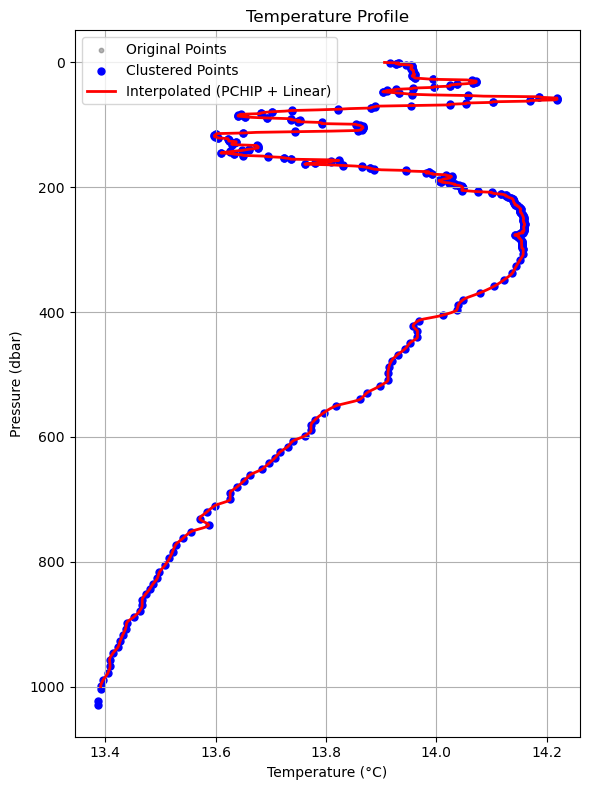

In [9]:
# --- Filter and prepare data for a specific station ---

# Extract data for station 045
station_045_profile = float_data[float_data['station_number'] == '045']

# Keep only rows with non-null temperature and salinity
filtered_profile = station_045_profile[
    station_045_profile['temperature'].notna() &
    station_045_profile['salinity'].notna()
]

# Keep only ascending profiles (e.g., upcast)
filtered_profile = filtered_profile[filtered_profile['phasename'] == 'ASC']

# Sort by pressure (ascending) and select relevant columns
filtered_profile = filtered_profile.sort_values(by='pressure')
filtered_profile = filtered_profile[['pressure', 'temperature', 'salinity']]

# Reset index after filtering and sorting
filtered_profile = filtered_profile.reset_index(drop=True)

# --- Prepare for interpolation ---

# Rename for clarity
cleaned_profile = filtered_profile

# Extract values for interpolation
pressures = cleaned_profile['pressure'].values
temperatures = cleaned_profile['temperature'].values
salinities = cleaned_profile['salinity'].values

# Define interpolation depths: 0 to 1000 m at 1 m resolution
interp_depths = np.arange(0, 1001, 1)

# --- Interpolators ---

# Create PCHIP interpolators (shape-preserving, no extrapolation)
pchip_temp = PchipInterpolator(pressures, temperatures, extrapolate=False)
pchip_sal = PchipInterpolator(pressures, salinities, extrapolate=False)

# If profile does not start at 0 dbar, prepare linear extrapolator for shallow end
min_p = pressures.min()
if min_p > 0:
    # Use first two shallowest points for linear extrapolation to surface
    p_shallow = pressures[:2]
    t_shallow = temperatures[:2]
    s_shallow = salinities[:2]

    linear_temp = interp1d(p_shallow, t_shallow, fill_value="extrapolate", kind="linear")
    linear_sal = interp1d(p_shallow, s_shallow, fill_value="extrapolate", kind="linear")
else:
    linear_temp = None
    linear_sal = None

# --- Interpolate across grid ---

# Initialize arrays with NaNs
interp_temp = np.full_like(interp_depths, np.nan, dtype=float)
interp_sal = np.full_like(interp_depths, np.nan, dtype=float)

# Fill interpolation arrays
for i, z in enumerate(interp_depths):
    if z < min_p:
        # Use linear extrapolation above observed range
        interp_temp[i] = linear_temp(z) if linear_temp else np.nan
        interp_sal[i] = linear_sal(z) if linear_sal else np.nan
    elif z <= pressures.max():
        # Use PCHIP interpolation within observed data range
        interp_temp[i] = pchip_temp(z)
        interp_sal[i] = pchip_sal(z)
    # else: remains NaN (deeper than profile)

# --- Create final interpolated DataFrame ---

interp_profile = pd.DataFrame({
    'pressure': interp_depths,
    'temperature': interp_temp,
    'salinity': interp_sal
})

# Save to CSV
interp_profile.to_csv('interp_profile.csv', index=False)

# Plot temperature profile
plt.figure(figsize=(6, 8))
plt.gca().invert_yaxis()  # So surface is at the top

# Plot original points
plt.scatter(filtered_profile['temperature'], filtered_profile['pressure'], 
            label='Original Points', color='gray', s=10, alpha=0.6)

# Plot clustered (deduplicated) points
plt.scatter(cleaned_profile['temperature'], cleaned_profile['pressure'], 
            label='Clustered Points', color='blue', s=25)

# Plot interpolated profile (PCHIP + linear)
plt.plot(interp_profile['temperature'], interp_profile['pressure'], 
         label='Interpolated (PCHIP + Linear)', color='red', linewidth=2)

# Labels and legend
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (dbar)')
plt.title('Temperature Profile')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### --> Use modified MATLAB code from Cauchy to calculate beta

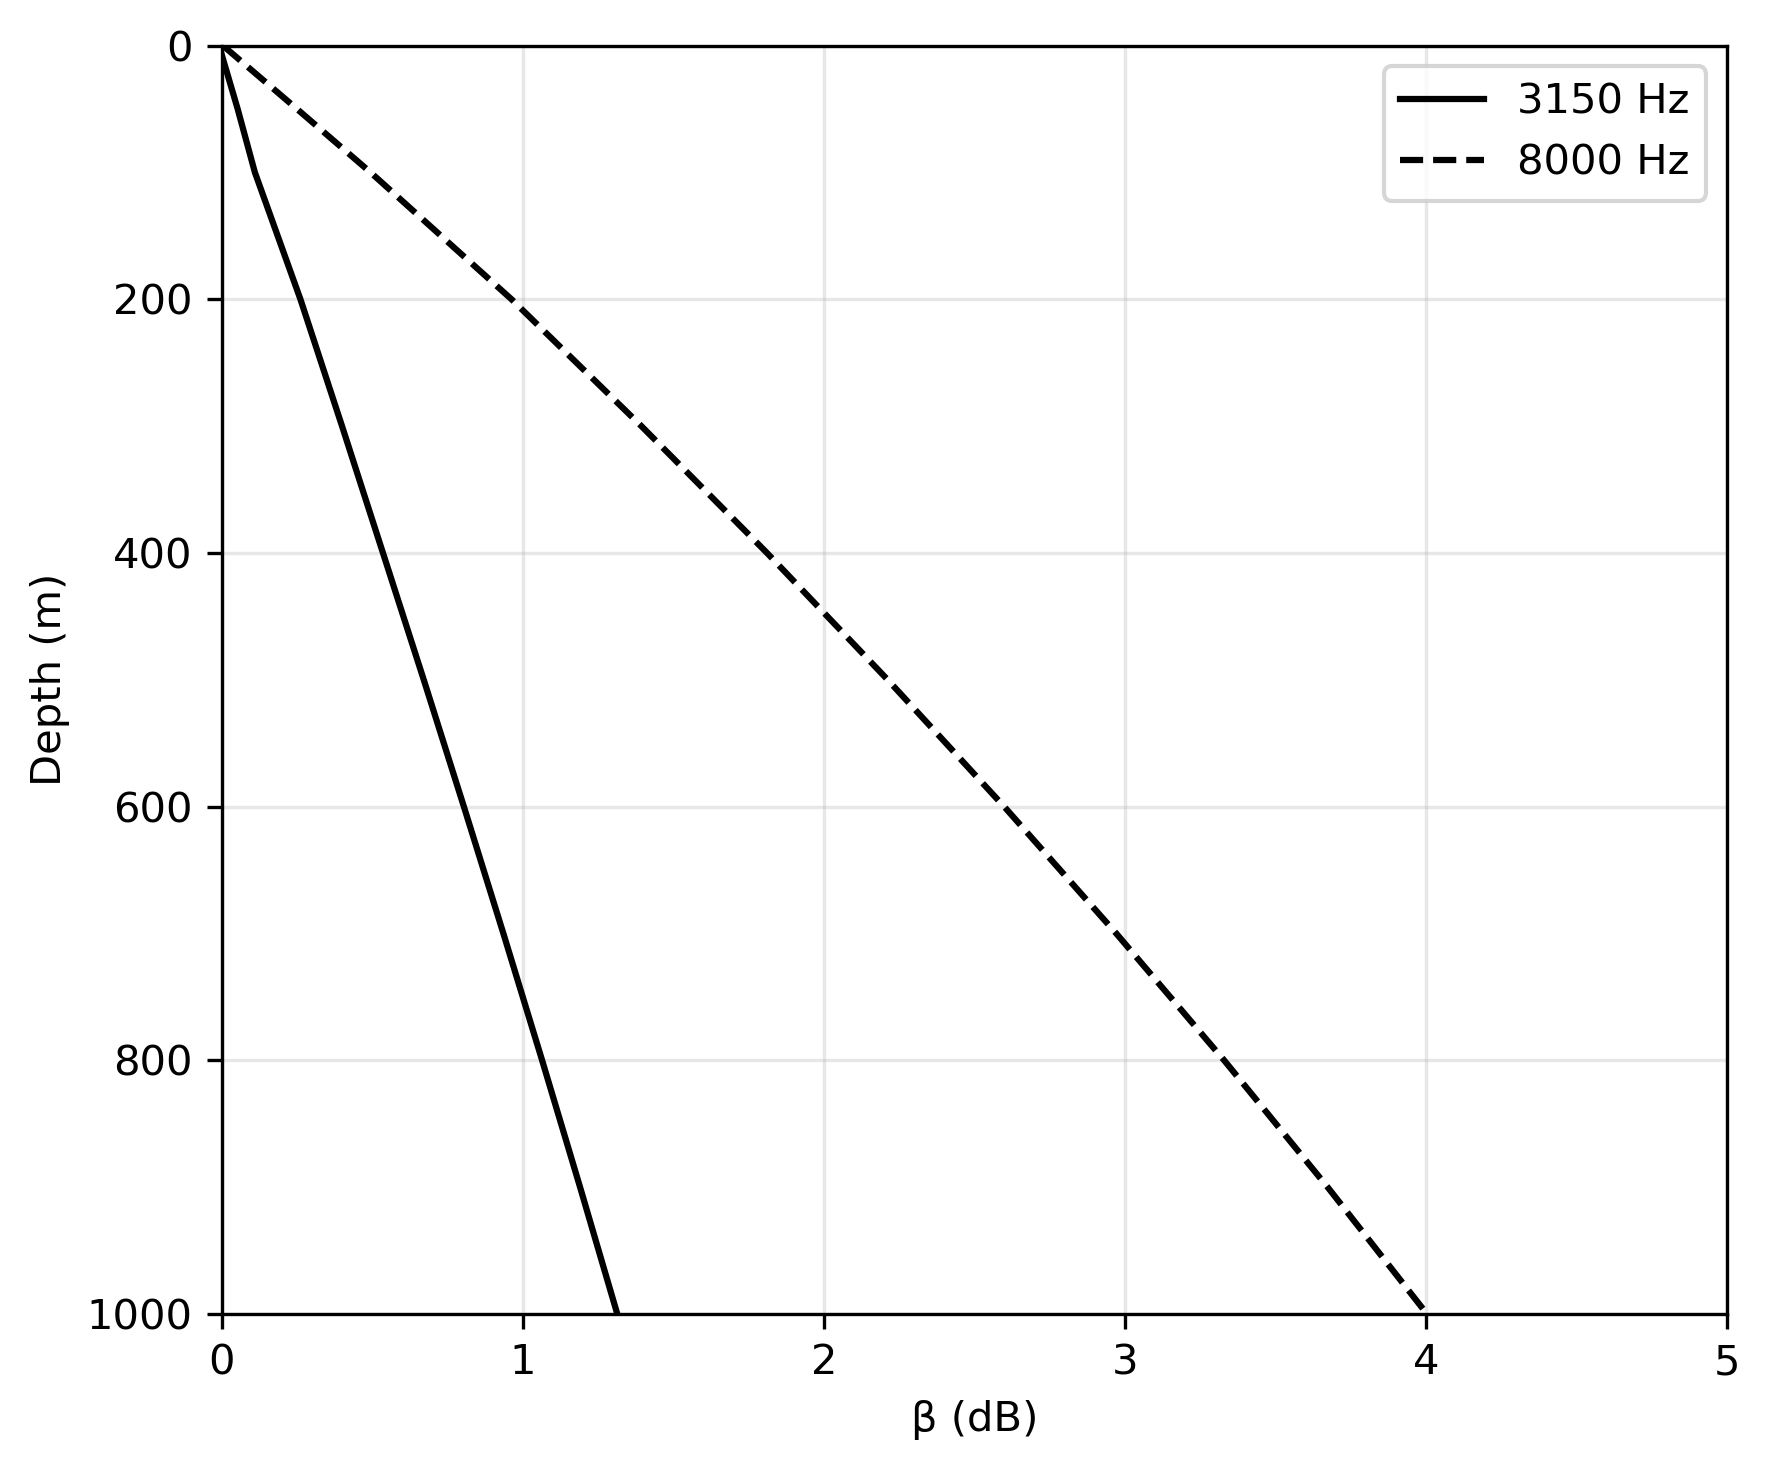

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load beta values from MATLAB run
beta_df = pd.read_csv("data/beta_profile_output.csv")

# Convert complex strings to Python complex numbers and extract real part
beta_df['Beta_dB_f3150'] = beta_df['Beta_dB_f3150'].apply(lambda x: complex(str(x).replace('i', 'j'))).apply(np.real)
beta_df['Beta_dB_f8000'] = beta_df['Beta_dB_f8000'].apply(lambda x: complex(str(x).replace('i', 'j'))).apply(np.real)

# Interpolate/extrapolate to 0 m using first two points
d1, d2 = beta_df['Depth_m'].iloc[0], beta_df['Depth_m'].iloc[1]
b1_3150, b2_3150 = beta_df['Beta_dB_f3150'].iloc[0], beta_df['Beta_dB_f3150'].iloc[1]
b1_8000, b2_8000 = beta_df['Beta_dB_f8000'].iloc[0], beta_df['Beta_dB_f8000'].iloc[1]

# Linear extrapolation to 0 m
beta_0_3150 = b1_3150 + (b1_3150 - b2_3150) / (d1 - d2) * (0 - d1)
beta_0_8000 = b1_8000 + (b1_8000 - b2_8000) / (d1 - d2) * (0 - d1)

# Insert new row at the top
beta_df_extended = pd.concat([
    pd.DataFrame({
        'Depth_m': [0],
        'Beta_dB_f3150': [beta_0_3150],
        'Beta_dB_f8000': [beta_0_8000]
    }),
    beta_df
], ignore_index=True)

# Plot using fig, ax
fig, ax = plt.subplots(figsize=(6, 5), dpi=300)
ax.plot(beta_df_extended['Beta_dB_f3150'], beta_df_extended['Depth_m'], c='k', label='3150 Hz')
ax.plot(beta_df_extended['Beta_dB_f8000'], beta_df_extended['Depth_m'], c='k', linestyle='--', label='8000 Hz')

# Customize plot
ax.set_xlabel('β (dB)')
ax.set_ylabel('Depth (m)')
ax.set_xlim(0, 5)
ax.set_ylim(0, 1000)
ax.invert_yaxis()
ax.grid(True, alpha=0.3)
ax.legend()
fig.tight_layout()
fig.savefig("figs/beta_profile.png", dpi=300, bbox_inches='tight')
plt.show()


In [30]:
# Create interpolation functions (with extrapolation enabled)
interp_3150 = interp1d(beta_df["Depth_m"], beta_df["Beta_dB_f3150"], bounds_error=False, fill_value="extrapolate")
interp_8000 = interp1d(beta_df["Depth_m"], beta_df["Beta_dB_f8000"], bounds_error=False, fill_value="extrapolate")

# Interpolate beta for each row based on pressure
float_data["beta_f3150"] = interp_3150(float_data["pressure"])
float_data["beta_f8000"] = interp_8000(float_data["pressure"])

# Apply correction (i.e., add beta)
float_data["f_3150Hz_corrected"] = float_data["f_3150Hz"] + float_data["beta_f3150"]
float_data["f_8000Hz_corrected"] = float_data["f_8000Hz"] + float_data["beta_f8000"]


In [31]:
float_data

,station_number,latitude,longitude,pressure,datetime_DO,phasename,doxy,datenum,datetime_SBE41,temperature,...,year,month,day,U_DYFAMED,distance_km,norm_distance,beta_f3150,beta_f8000,f_3150Hz_corrected,f_8000Hz_corrected
0,041,43.395203,7.867331,521.1,2025-02-10 15:43:12,PAR,200.177167,20129.655000,2025-02-10 15:43:05,13.8528,...,2025,2,10,4.2,3.464440,0.036099,0.699058,2.294057,52.362588,44.908174
1,041,43.395203,7.867331,710.6,2025-02-10 16:43:24,PAR,199.228962,20129.696806,2025-02-10 16:43:04,13.5930,...,2025,2,10,3.7,3.464440,0.036099,0.949154,3.009928,51.485582,44.687070
2,041,43.395203,7.867331,531.8,2025-02-10 17:43:36,PAR,196.783409,20129.738611,2025-02-10 17:43:04,13.8312,...,2025,2,10,3.7,3.464440,0.036099,0.713326,2.335475,49.704841,42.246384
3,041,43.395203,7.867331,496.5,2025-02-10 18:43:48,PAR,196.879034,20129.780417,2025-02-10 18:43:04,13.8778,...,2025,2,10,3.7,3.464440,0.036099,0.666179,2.198346,47.187997,40.730467
4,041,43.395203,7.867331,497.7,2025-02-10 19:44:01,PAR,198.040165,20129.822234,2025-02-10 19:43:04,13.8662,...,2025,2,10,NaN,3.464440,0.036099,0.667805,2.203158,44.280533,39.420217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12623,060,43.363777,7.730860,0.0,2025-03-17 05:07:49,SUR,309.854925,20164.213762,NaT,NaN,...,2025,3,17,4.4,8.234715,0.100488,-0.009278,0.003243,NaN,NaN
12624,060,43.363777,7.730860,0.0,2025-03-17 05:07:59,SUR,314.467588,20164.213877,NaT,NaN,...,2025,3,17,4.4,8.234715,0.100488,-0.009278,0.003243,NaN,NaN
12625,060,43.363777,7.730860,0.2,2025-03-17 05:08:09,SUR,291.443546,20164.213993,NaT,NaN,...,2025,3,17,4.4,8.234715,0.100488,-0.009031,0.004228,NaN,NaN
12626,060,43.363777,7.730860,0.0,2025-03-17 05:08:19,SUR,314.133525,20164.214109,NaT,NaN,...,2025,3,17,4.4,8.234715,0.100488,-0.009278,0.003243,NaN,NaN


In [123]:
mean_beta

{3.15: array([-0.57689895, -0.18728431, -0.16441472, -0.10128516, -0.11366925,
        -0.11020719, -0.08857123, -0.05879064, -0.02257991,  0.03087107,
         0.09307483,  0.13096055]),
 8.0: array([-0.56524245, -0.15359405, -0.08693779,  0.05684369,  0.12052011,
         0.19383951,  0.28343359,  0.38217876,  0.48636652,  0.59932109,
         0.71418334,  0.81115751])}

## 6 - Fit already-existing algorithms

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === Wind Speed Model Functions ===

def nystuen2015(TOL):
    return 0.0005 * TOL**3 - 0.0310 * TOL**2 + 0.4904 * TOL + 2.0871

def vagle1990(TOL):
    A = 7.38
    B = -38.70
    C = TOL - 21.69
    discriminant = B**2 - 4 * A * C
    result = np.full_like(TOL, np.nan, dtype=np.float64)
    mask = discriminant >= 0
    root_term = np.sqrt(discriminant[mask])
    exponent = (-B - root_term) / (2 * A)
    result[mask] = 10 ** exponent
    return result

def pensieri2015(TOL):
    TOL = np.asarray(TOL)
    result = np.full_like(TOL, np.nan, dtype=np.float64)
    mask1 = TOL < 38
    mask2 = (TOL >= 38) & (TOL < 60)
    result[mask1] = 0.1458 * TOL[mask1] - 3.146
    result[mask2] = 0.044642 * TOL[mask2]**2 - 3.2917 * TOL[mask2] + 63.016
    return result

def cauchy2018(SPL_dB, S_off=0):
    SPL_dB = np.asarray(SPL_dB)
    corrected_SPL = SPL_dB - S_off
    p = 10 ** (corrected_SPL / 20)

    # Define model coefficients from paper
    s_low = 0.4e4
    b_low = 0.2e4
    s_high = 1.6e4
    b_high = 12.5e4

    # Compute both regimes
    U_low = (p + b_low) / s_low
    U_high = (p + b_high) / s_high

    # Apply switching based on U_low threshold
    return np.where(U_low > 10, U_high, U_low)

# === S_off based on min SPL ===
S_off_cauchy = np.nanmin(float_data["f_3150Hz"])

# === Apply models ===
float_data["U_nystuen_litt_coeffs"] = nystuen2015(float_data["f_8000Hz"])
float_data["U_vagle_litt_coeffs"] = vagle1990(float_data["f_8000Hz"])
float_data["U_pensieri_litt_coefs"] = pensieri2015(float_data["f_8000Hz"])
float_data["U_cauchy_litt_coefs"] = cauchy2018(float_data["f_3150Hz"], S_off=S_off_cauchy)

### Plot

NameError: name 'deployment_boundary' is not defined

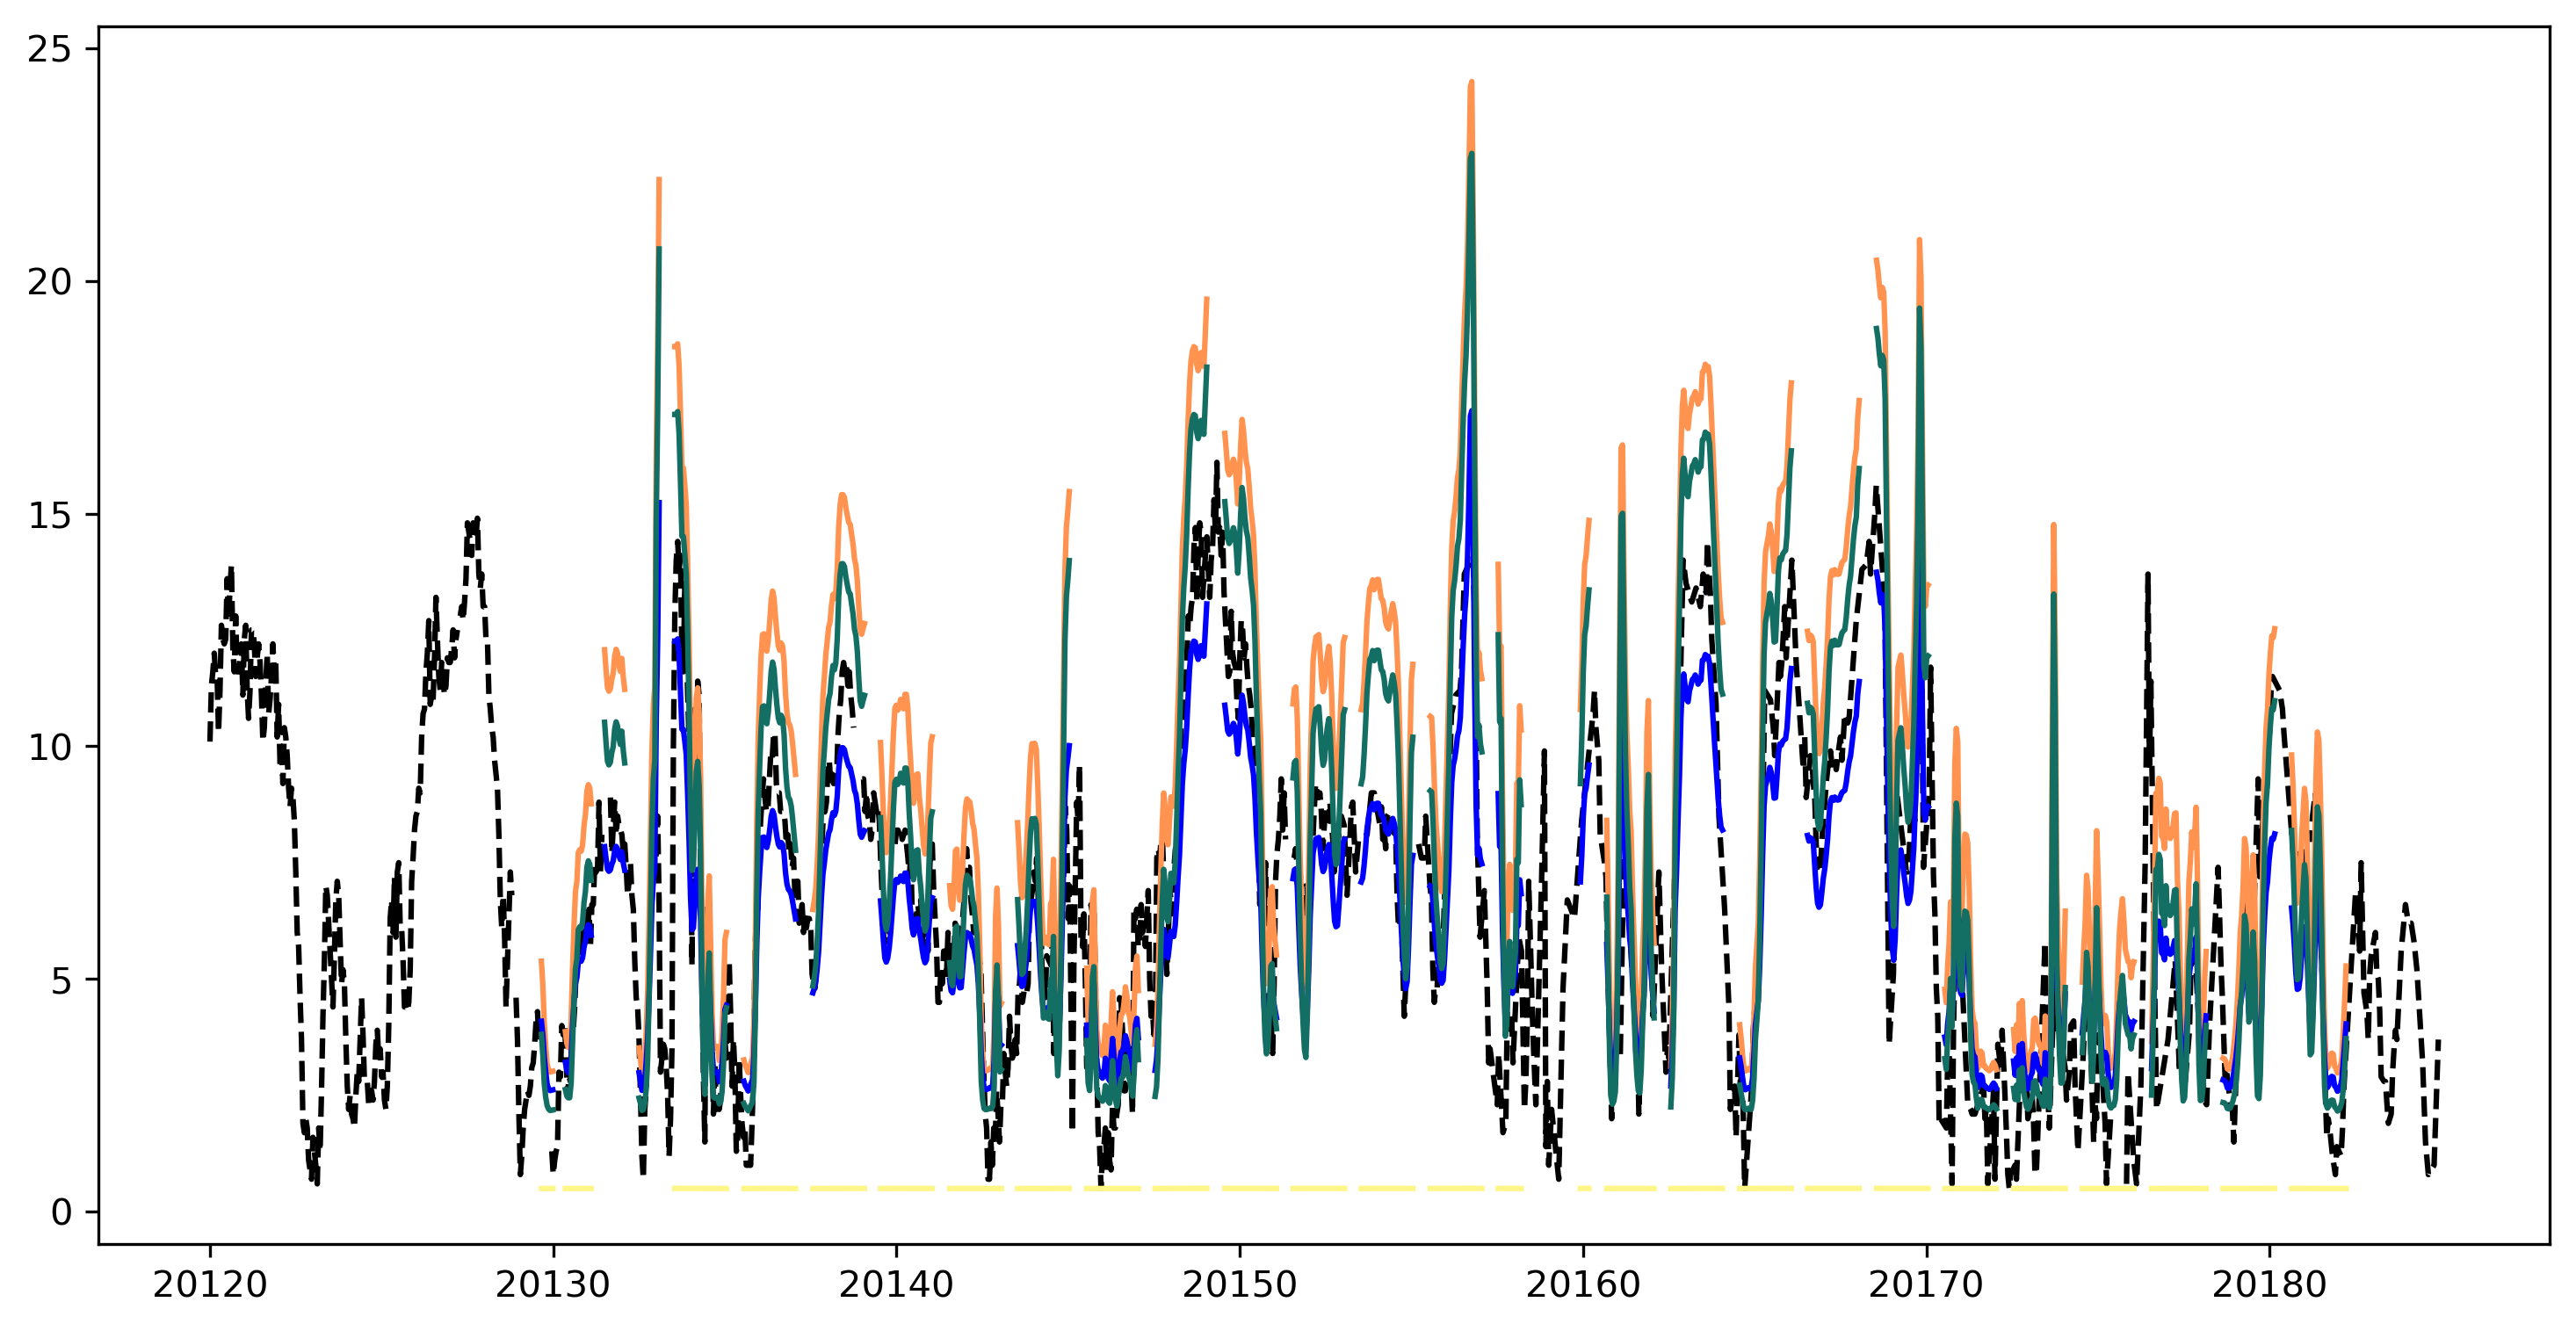

In [24]:
# === Plot Results ===
plt.figure(figsize=(12, 6), dpi=300)

# Observed
plt.plot(wind_data["datenum"], wind_data["U_DYFAMED"], c='k', linestyle='--', label="Wind Speed (DYFAMED buoy)")

# Models
plt.plot(float_data["datenum"], float_data["U_nystuen_litt_coeffs"], c="#ff934f", label="Nystuen et al. (2015)")
plt.plot(float_data["datenum"], float_data["U_vagle_litt_coeffs"], linestyle='-', c='b', label="Vagle et al. (1990)")
plt.plot(float_data["datenum"], float_data["U_pensieri_litt_coefs"], c="#136f63", label="Pensieri et al. (2015)")
plt.plot(float_data["datenum"], float_data["U_cauchy_litt_coefs"], c="#fff689", label="Cauchy et al. (2018)")

# Optional:
# plt.plot(float_data["datenum"], float_data["U_hildebrand_litt_coefs"], c="#0d1321", label="Hildebrand (2021)")

# Formatting
plt.axvline(deployment_boundary, color='black', linestyle='--', linewidth=1, label="Start of deployment B")
plt.xlabel("Datetime")
plt.ylabel("Wind Speed (m/s)")
plt.xlim(float_data["datenum"].min(), float_data["datenum"].max())
plt.grid(alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend(loc="upper left", bbox_to_anchor=(0.1, -0.1), ncols=3)
plt.show()


## X - Process AIS data

### Parse AIS files

In [ ]:
# import os
# import gzip
# import pandas as pd
# import ais.stream
# import re

# # --- Config ---
# LIMIT_FILES = None  # Set to an integer to limit how many files are processed

# base_dir = r"C:\Users\louis\Documents\GitHub\tricuso-init\data\AIS"
# output_dir = os.path.join(base_dir, "parsed")
# os.makedirs(output_dir, exist_ok=True)

# # --- Vessel type lookup ---
# type_lookup = {
#     0: 'Not available',
#     **{k: 'Reserved' for k in range(1, 20)},
#     20: 'WIG', 21: 'WIG - Hazardous A', 22: 'WIG - Hazardous B', 23: 'WIG - Hazardous C', 24: 'WIG - Hazardous D',
#     **{k: 'WIG - Reserved' for k in range(25, 30)},
#     30: 'Fishing', 31: 'Towing', 32: 'Towing - long', 33: 'Dredging or underwater ops', 34: 'Diving ops',
#     35: 'Military ops', 36: 'Sailing', 37: 'Pleasure craft', 38: 'Reserved', 39: 'Reserved',
#     40: 'HSC', 41: 'HSC - Hazardous A', 42: 'HSC - Hazardous B', 43: 'HSC - Hazardous C', 44: 'HSC - Hazardous D',
#     **{k: 'HSC - Reserved' for k in range(45, 49)}, 49: 'HSC - No additional info',
#     50: 'Pilot vessel', 51: 'Search and rescue', 52: 'Tug', 53: 'Port tender',
#     54: 'Anti-pollution', 55: 'Law enforcement', 56: 'Local vessel (spare)', 57: 'Local vessel (spare)',
#     58: 'Medical transport', 59: 'Noncombatant under RR Res. No. 18',
#     60: 'Passenger', 61: 'Passenger - Hazardous A', 62: 'Passenger - Hazardous B',
#     63: 'Passenger - Hazardous C', 64: 'Passenger - Hazardous D',
#     **{k: 'Passenger - Reserved' for k in range(65, 69)}, 69: 'Passenger - No additional info',
#     70: 'Cargo', 71: 'Cargo - Hazardous A', 72: 'Cargo - Hazardous B', 73: 'Cargo - Hazardous C', 74: 'Cargo - Hazardous D',
#     **{k: 'Cargo - Reserved' for k in range(75, 79)}, 79: 'Cargo - No additional info',
#     80: 'Tanker', 81: 'Tanker - Hazardous A', 82: 'Tanker - Hazardous B',
#     83: 'Tanker - Hazardous C', 84: 'Tanker - Hazardous D',
#     **{k: 'Tanker - Reserved' for k in range(85, 89)}, 89: 'Tanker - No additional info',
#     90: 'Other', 91: 'Other - Hazardous A', 92: 'Other - Hazardous B', 93: 'Other - Hazardous C',
#     94: 'Other - Hazardous D', **{k: 'Other - Reserved' for k in range(95, 99)}, 99: 'Other - No additional info'
# }

# def decode_type(type_code):
#     if pd.isna(type_code):
#         return None
#     try:
#         return type_lookup.get(int(type_code), 'Unknown')
#     except:
#         return 'Unknown'

# # --- File Discovery ---
# files = sorted([f for f in os.listdir(base_dir) if f.startswith("messages-")])
# if LIMIT_FILES is not None:
#     files = files[:LIMIT_FILES]

# # --- Main Loop ---
# for filename in files:
#     if not filename.startswith("messages-"):
#         continue

#     # Extract date from filename
#     match = re.match(r"messages-(\d{4})(\d{2})(\d{2})(?:\.gz)?$", filename)
#     if not match:
#         print(f"⚠️ Skipping file with unexpected format: {filename}")
#         continue
#     year, month, day = map(int, match.groups())

#     filepath = os.path.join(base_dir, filename)
#     opener = gzip.open if filename.endswith(".gz") else open

#     messages = []
#     print(f"📦 Processing {filename}")

#     try:
#         with opener(filepath, mode='rt', encoding='utf-8', errors='ignore') as f:
#             for msg in ais.stream.decode(f):
#                 if isinstance(msg, dict):
#                     messages.append(msg)

#         # Convert to DataFrame
#         df_chunk = pd.DataFrame(messages)

#         # Drop rows without valid lat/lon
#         df_chunk = df_chunk.dropna(subset=['x', 'y'])

#         # Add vessel type
#         df_chunk['vessel_type'] = df_chunk['type_and_cargo'].apply(decode_type)

#         # Add file date info
#         df_chunk['file_year'] = year
#         df_chunk['file_month'] = month
#         df_chunk['file_day'] = day

#         # Save to unique file
#         output_filename = f"ais_positions_{year:04d}{month:02d}{day:02d}.csv"
#         output_path = os.path.join(output_dir, output_filename)
#         df_chunk.to_csv(output_path, index=False)

#         print(f"✅ Saved {len(df_chunk)} rows to {output_filename}")

#     except Exception as e:
#         print(f"❌ Failed to process {filename}: {e}")


In [ ]:
import pandas as pd
import numpy as np
from pyproj import Geod
from datetime import timedelta
from haversine import haversine, Unit
from glob import glob
import os

# Load float data and parse datetimes
float_data = pd.read_csv("data/sea_trials_do_sbe41_pal.csv")
float_data['datetime_DO'] = pd.to_datetime(float_data['datetime_DO'], errors='coerce')
float_data['nearby_ships'] = np.nan  # prefill with NaN

# Interpolate float trajectory
geod = Geod(ellps="WGS84")
stations_df = float_data[["station_number", "latitude", "longitude", "datetime_DO"]].drop_duplicates(
    subset=["station_number", "latitude", "longitude"]
).sort_values("datetime_DO").reset_index(drop=True)

interpolated_rows = []
for i in range(len(stations_df) - 1):
    start = stations_df.iloc[i]
    end = stations_df.iloc[i + 1]
    start_time = pd.to_datetime(start["datetime_DO"])
    end_time = pd.to_datetime(end["datetime_DO"])
    duration_hours = int((end_time - start_time).total_seconds() // 3600)
    if duration_hours <= 0:
        continue
    lonlats = geod.npts(start["longitude"], start["latitude"], end["longitude"], end["latitude"], duration_hours - 1)
    interpolated_rows.append({"datetime": start_time, "latitude_interp": start["latitude"], "longitude_interp": start["longitude"]})
    for j, (lon, lat) in enumerate(lonlats):
        interpolated_rows.append({"datetime": start_time + timedelta(hours=j + 1), "latitude_interp": lat, "longitude_interp": lon})
interpolated_rows.append({
    "datetime": stations_df.iloc[-1]["datetime_DO"],
    "latitude_interp": stations_df.iloc[-1]["latitude"],
    "longitude_interp": stations_df.iloc[-1]["longitude"]
})
interp_df = pd.DataFrame(interpolated_rows)
interp_df["datetime"] = pd.to_datetime(interp_df["datetime"])

# Merge interpolated trajectory with float_data
float_data = pd.merge_asof(
    float_data.sort_values("datetime_DO"),
    interp_df.sort_values("datetime"),
    left_on="datetime_DO",
    right_on="datetime",
    direction="nearest"
)

# Loop through AIS files
radius_km = 20
time_window_minutes = 30
data_folder = "data/AIS/parsed/"
bounding_box = (6.5, 8.0, 43.0, 44.0)

for filepath in glob(os.path.join(data_folder, "ais_positions_*.csv")):
    print(f"Processing {filepath}")
    
    try:
        ais = pd.read_csv(filepath, on_bad_lines='skip', low_memory=False)
        ais = ais.dropna(subset=['utc_hour', 'utc_min', 'x', 'y'])

        west, east, south, north = bounding_box
        ais = ais[
            (ais['x'] >= west) & (ais['x'] <= east) &
            (ais['y'] >= south) & (ais['y'] <= north)
        ]

        ais['datetime'] = pd.to_datetime(dict(
            year=ais['file_year'].astype(int),
            month=ais['file_month'].astype(int),
            day=ais['file_day'].astype(int),
            hour=ais['utc_hour'].astype(int),
            minute=ais['utc_min'].astype(int)
        ), errors='coerce')

        if ais.empty:
            continue

        # Determine the date of this AIS file
        ais_date = ais['datetime'].dt.date.unique()[0]
        float_mask = float_data['datetime_DO'].dt.date == ais_date

        if not float_mask.any():
            continue

        # Subset float_data to rows for this date
        float_subset = float_data[float_mask].copy()
        ship_counts = []

        for _, float_row in float_subset.iterrows():
            lat_f = float_row['latitude_interp']
            lon_f = float_row['longitude_interp']
            time_f = float_row['datetime_DO']

            if pd.isna(time_f) or pd.isna(lat_f) or pd.isna(lon_f):
                ship_counts.append(np.nan)
                continue

            start = time_f - pd.Timedelta(minutes=time_window_minutes)
            end = time_f + pd.Timedelta(minutes=time_window_minutes)

            ais_window = ais[(ais['datetime'] >= start) & (ais['datetime'] <= end)]
            ais_dedup = ais_window.sort_values('datetime').drop_duplicates(subset='mmsi', keep='first')

            distances = ais_dedup.apply(
                lambda row: haversine((lat_f, lon_f), (row['y'], row['x']), unit=Unit.KILOMETERS),
                axis=1
            )
            ship_counts.append((distances <= radius_km).sum())

        # Insert results for that day only
        float_data.loc[float_mask, 'nearby_ships'] = ship_counts

    except Exception as e:
        print(f"Error in {filepath}: {e}")
        continue

import matplotlib.pyplot as plt
import pandas as pd

# Compute diff
float_data['U_diff'] = float_data['U_nystuen_opt_coeffs'] - float_data['U_DYFAMED']

# Ensure datetime format and sorting
float_data = float_data.sort_values('datetime')
float_data['datetime'] = pd.to_datetime(float_data['datetime'])

# Compute RMSE
rmse = (float_data['U_diff']**2).mean()**0.5

# Find ship times
ship_times = float_data[float_data['nearby_ships'] > 0]['datetime']

# Define "significant deviation + ship nearby"
def highlight_condition(dt, diff):
    is_significant = abs(diff) > rmse
    is_ship_nearby = any(abs((dt - ship_time).total_seconds()) <= 1800 for ship_time in ship_times)
    return is_significant and is_ship_nearby

float_data['highlight'] = float_data.apply(
    lambda row: highlight_condition(row['datetime'], row['U_diff']), axis=1
)

# Plot
fig, ax = plt.subplots(figsize=(15, 6))

# Segment-wise coloring
current_color = None
segment_x, segment_y = [], []

for idx, row in float_data.iterrows():
    color = 'red' if row['highlight'] else 'tab:blue'
    if current_color is None:
        current_color = color

    if color != current_color and segment_x:
        ax.plot(segment_x, segment_y, color=current_color)
        segment_x, segment_y = [], []
        current_color = color

    segment_x.append(row['datetime'])
    segment_y.append(row['U_diff'])

# Final segment
if segment_x:
    ax.plot(segment_x, segment_y, color=current_color)

# Labels and layout
ax.set_xlabel('Time')
ax.set_ylabel('U Difference (m/s)')
ax.set_title(f'Deviation U Float - U DYFAMED (Red = |Diff| > RMSE ≈ {rmse:.2f} & Ship Nearby)')
ax.grid(True)

plt.tight_layout()
plt.show()

float_data = float_data[~float_data['highlight']]

float_data.to_csv("data/sea_trials_do_sbe41_pal_pco2_depth_corrected_wind_opt_fits_ERA5_postAIS.csv")
